In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms
from torchsummary import summary
import torch.nn.functional as F
import torchaudio
from torch.utils.data.sampler import SubsetRandomSampler
import os
import datetime
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import utils.utils_base as uBase
from models.KSL_EFFI_v2 import EfficientNet
from dataset_MT_KWS import MC_MT_KWS_Dataset, Overlap_interference
from IPython.display import Audio
from dataset_MT_newData import new_Dataset

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

encoder_ch = [[6,64],[64,128],[128,256],[256,256]]
net = EfficientNet().cuda()
learning_rate = 0.0005


optimizer = optim.Adam(net.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[14,18,23], gamma=0.1)

coarse_loss = nn.CrossEntropyLoss(reduction="sum")
fine_loss = nn.MSELoss(reduction="sum")
cls_loss = nn.BCELoss(reduction="sum")
ext_loss = nn.L1Loss(reduction="sum")
b = 0

annotation = "newData3.csv"

train_annotation = 'newData3_train.csv'
valid_annotation = 'newData3_valid.csv'
test_annotation = 'newData3_test.csv'

train_dataset = new_Dataset(annotations_file=train_annotation)
valid_dataset = new_Dataset(annotations_file=valid_annotation)
test_dataset = new_Dataset(annotations_file=test_annotation)


batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=10)


#sgS_weight_path = "weight/20230126-143Drop/16.pt" # single-task (spotting)
sgS_weight_path = "weight/20230228-211newData/33.pt" # single-task (spotting)
#sgL_weight_path = "weight/20230126-092Drop/14.pt" # single-task (Localization)
sgL_weight_path = "weight/20230228-173newData/33.pt" # single-task (Localization)
mt_weight_path = "weight/20230216-093Drop/12.pt" # Multi-task


#net.load_state_dict(torch.load(weight_path))

def relu_fn(x):
    """ Swish activation function """
    return x * torch.sigmoid(x)

class LayerResult:
    def __init__(self, payers, layer_index):
        self.hook = payers[layer_index]._bn2.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.features = relu_fn(output).cpu().data.numpy()
        #self.features = output.cpu().data.numpy()
    
    def unregister_forward_hook(self):
        self.hook.remove()

class first_conv_act:
    def __init__(self, hi):
        self.hook = hi._bn0.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.features = relu_fn(output).cpu().data.numpy()
        #self.features = output.cpu().data.numpy()
    
    def unregister_forward_hook(self):
        self.hook.remove()
        
class last_conv_act:
    def __init__(self, hi):
        self.hook = hi._bn1.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.features = relu_fn(output).cpu().data.numpy()
        #self.features = output.cpu().data.numpy()
    
    def unregister_forward_hook(self):
        self.hook.remove()
        

class SEResult:
    def __init__(self, payers, layer_index):
        self.hook = payers[layer_index]._se_expand.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.features = torch.sigmoid(output).cpu().data.numpy()
    
    def unregister_forward_hook(self):
        self.hook.remove()


def get_activations(weight_file, x_sg):
    net = EfficientNet().cuda()
    net.load_state_dict(torch.load(weight_file))
    net.eval()
    
    result0 = first_conv_act(net)
    result1 = LayerResult(net._blocks, 0)
    result2 = LayerResult(net._blocks, 1)
    result3 = LayerResult(net._blocks, 2)
    result4 = LayerResult(net._blocks, 3)
    result5 = LayerResult(net._blocks, 4)
    result6 = LayerResult(net._blocks, 5)
    result7 = LayerResult(net._blocks, 6)
    result8 = LayerResult(net._blocks, 7)
    result9 = last_conv_act(net)

    se_result1 = SEResult(net._blocks, 0)
    se_result2 = SEResult(net._blocks, 1)
    se_result3 = SEResult(net._blocks, 2)
    se_result4 = SEResult(net._blocks, 3)
    se_result5 = SEResult(net._blocks, 4)
    se_result6 = SEResult(net._blocks, 5)
    se_result7 = SEResult(net._blocks, 6)
    se_result8 = SEResult(net._blocks, 7)


    out_localizer1, out_localizer2 = net(x_sg)

    acts = []
    act_first = result0.features
    act_last = result9.features
    activations1 = result1.features
    activations2 = result2.features
    activations3 = result3.features
    activations4 = result4.features
    activations5 = result5.features
    activations6 = result6.features
    activations7 = result7.features
    activations8 = result8.features
    acts.append([activations1, activations2, activations3, activations4, activations5, activations6, activations7, activations8])

    se_acts = []
    se_activation1 = se_result1.features
    se_activation2 = se_result2.features
    se_activation3 = se_result3.features
    se_activation4 = se_result4.features
    se_activation5 = se_result5.features
    se_activation6 = se_result6.features
    se_activation7 = se_result7.features
    se_activation8 = se_result8.features
    se_acts.append([se_activation1, se_activation2, se_activation3, se_activation4, se_activation5, se_activation6, se_activation7, se_activation8])
    
    return acts[0], se_acts[0], act_first, act_last, net

idx = 1
ccount = 0
for batch_index, (x_sg, y_region, y_angle, y_class, bce, _) in enumerate(valid_dataloader):
    x_sg = x_sg[idx:idx+1].cuda()
    #out_localizer1, out_localizer2, out_detector = net(x_sg)
    ccount += 1
    if ccount == 7:
        break

    
mt_acts, mt_se_acts, f_mt_act, l_mt_act, mt_net = get_activations(mt_weight_path, x_sg)
sgS_acts, sgS_se_acts, f_s_act, l_s_act, spot_net = get_activations(sgS_weight_path, x_sg)
sgL_acts, sgL_se_acts, f_l_act, l_l_act, local_net = get_activations(sgL_weight_path, x_sg)
"""
print(activations1.shape)
print(activations2.shape)
print(activations3.shape)
print(activations4.shape)
print(activations5.shape)

print(se_activation1.shape)
print(se_activation2.shape)
print(se_activation3.shape)
print(se_activation4.shape)
print(se_activation5.shape)
"""

'\nprint(activations1.shape)\nprint(activations2.shape)\nprint(activations3.shape)\nprint(activations4.shape)\nprint(activations5.shape)\n\nprint(se_activation1.shape)\nprint(se_activation2.shape)\nprint(se_activation3.shape)\nprint(se_activation4.shape)\nprint(se_activation5.shape)\n'

In [6]:
net._blocks[0]._bn1

BatchNorm1d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)

In [4]:
net

EfficientNet(
  (_conv_stem): Conv1dSamePadding(6, 32, kernel_size=(3,), stride=(2,), bias=False)
  (_bn0): BatchNorm1d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv1dSamePadding(32, 32, kernel_size=(3,), stride=(1,), groups=32, bias=False)
      (_bn1): BatchNorm1d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (_se_reduce): Conv1dSamePadding(32, 8, kernel_size=(1,), stride=(1,))
      (_se_expand): Conv1dSamePadding(8, 32, kernel_size=(1,), stride=(1,))
      (_project_conv): Conv1dSamePadding(32, 16, kernel_size=(1,), stride=(1,), bias=False)
      (_bn2): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MBConvBlock(
      (_expand_conv): Conv1dSamePadding(16, 96, kernel_size=(1,), stride=(1,), bias=False)
      (_bn0): BatchNorm1d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (_depthwi

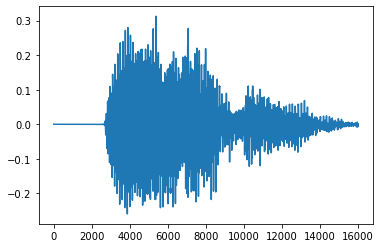

In [205]:
plt.plot(x_sg.cpu().numpy()[0][0])

In [195]:
sgL_se_acts[1][0]

array([[0.480027  ],
       [0.68138844],
       [0.417806  ],
       [0.36416873],
       [0.39983436],
       [0.3767951 ],
       [0.40248504],
       [0.44088632],
       [0.42454356],
       [0.575037  ],
       [0.5749604 ],
       [0.62327653],
       [0.52093065],
       [0.5143306 ],
       [0.33025253],
       [0.49499464],
       [0.429875  ],
       [0.651904  ],
       [0.42008212],
       [0.379549  ],
       [0.48568648],
       [0.5735364 ],
       [0.4625865 ],
       [0.42158934],
       [0.40655202],
       [0.54651564],
       [0.3808192 ],
       [0.41247195],
       [0.34166253],
       [0.44141266],
       [0.4559209 ],
       [0.42489746],
       [0.47061634],
       [0.57066983],
       [0.6215887 ],
       [0.42657316],
       [0.34080273],
       [0.35817063],
       [0.41233906],
       [0.53632176],
       [0.3833234 ],
       [0.42602232],
       [0.37163636],
       [0.5429493 ],
       [0.5308513 ],
       [0.47580576],
       [0.40874338],
       [0.411

In [196]:
sgS_se_acts[1][0]

array([[0.37733763],
       [0.41580632],
       [0.33131775],
       [0.25572187],
       [0.50395   ],
       [0.3430838 ],
       [0.38776556],
       [0.53755045],
       [0.5286375 ],
       [0.7290817 ],
       [0.38709018],
       [0.49225107],
       [0.17560932],
       [0.62203014],
       [0.20898105],
       [0.26596743],
       [0.14018467],
       [0.30191338],
       [0.5388395 ],
       [0.36085665],
       [0.57857627],
       [0.29583055],
       [0.10368177],
       [0.364168  ],
       [0.6280619 ],
       [0.7510514 ],
       [0.12367908],
       [0.22794685],
       [0.49096945],
       [0.07519577],
       [0.26222   ],
       [0.32302803],
       [0.15142377],
       [0.35444126],
       [0.12008701],
       [0.352848  ],
       [0.5045449 ],
       [0.5170469 ],
       [0.43510655],
       [0.12364636],
       [0.21353805],
       [0.27932256],
       [0.5656015 ],
       [0.36434633],
       [0.10214075],
       [0.1719733 ],
       [0.6735175 ],
       [0.298

In [5]:
def get_cosine_sim(f_s, f_l, a_s, a_l, l_s, l_l):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    cosine_sim = []
    out = torch.mean(cos(torch.tensor(f_s[0]), torch.tensor(f_l_act[0]))).numpy()
    #print(out.shape)
    cosine_sim.append(out)
    for i in range(0, 8):
        idx = i
        out = torch.mean(cos(torch.tensor(a_s[idx][0]), torch.tensor(a_l[idx][0]))).numpy()
        print(cos(torch.tensor(a_s[idx][0]), torch.tensor(a_l[idx][0])))
        cosine_sim.append(out)
        #print(out.shape)
    out = torch.mean(cos(torch.tensor(l_s[0]), torch.tensor(l_l[0]))).numpy()
    #print(out.shape)
    cosine_sim.append(out)
    return cosine_sim

In [6]:
bcd = get_cosine_sim(f_s_act, f_l_act, sgS_acts, sgL_acts, l_s_act, l_l_act)
print(bcd)

tensor([ 0.0575,  0.6209,  0.4733,  0.3823,  0.2311,  0.2625,  0.2490,  0.6469,
         0.2945,  0.7835,  0.1448, -0.0199,  0.1629,  0.2887,  0.3812,  0.4252])
tensor([ 0.1672,  0.2959,  0.3939,  0.4517,  0.6484,  0.0370,  0.4528,  0.6580,
         0.2333,  0.4307,  0.4615,  0.3259,  0.3896,  0.3398,  0.0736,  0.5616,
         0.1133, -0.0033,  0.2060,  0.2000,  0.4724,  0.5918,  0.2912,  0.6137])
tensor([ 0.0623,  0.1703, -0.0491, -0.2748,  0.7222, -0.3499,  0.1700,  0.0851,
         0.6258,  0.6619,  0.5362, -0.0495,  0.6972,  0.5511, -0.2152,  0.7854,
         0.2615,  0.7546,  0.4531, -0.2371,  0.6002,  0.7835,  0.4446,  0.4745])
tensor([ 0.1472,  0.4051,  0.1474,  0.0059,  0.4538,  0.4112,  0.5523,  0.1787,
         0.6388,  0.1643,  0.0880, -0.0504, -0.0733,  0.0320,  0.0113,  0.4148,
         0.2313,  0.6750,  0.3110,  0.2407,  0.4715,  0.2986,  0.4872,  0.0705,
        -0.1355,  0.4354,  0.3210,  0.0100, -0.0775,  0.6546,  0.2786,  0.5301,
         0.3255,  0.2353,  0.4379,  0

In [38]:
abc = 0
for batch_index, (x_sg, y_region, y_angle, y_class, bce, _) in enumerate(valid_dataloader):
    for i in range(len(x_sg)):
        temp = x_sg[i:i+1].cuda()
        sgS_acts, sgS_se_acts, f_s_act, l_s_act, spot_net = get_activations(sgS_weight_path, temp)
        sgL_acts, sgL_se_acts, f_l_act, l_l_act, local_net = get_activations(sgL_weight_path, temp)
        if batch_index == 0 and i == 0:
            abc = get_cosine_sim(f_s_act, f_l_act, sgS_acts, sgL_acts, l_s_act, l_l_act)
            abc = np.array(abc)
        else:
            abc += get_cosine_sim(f_s_act, f_l_act, sgS_acts, sgL_acts, l_s_act, l_l_act)
    if batch_index == 200:
        break

In [39]:
abc / (10 * (200 + 1))

array([0.5645223 , 0.31932887, 0.3055098 , 0.21758778, 0.2482145 ,
       0.1367144 , 0.15850563, 0.06797328, 0.1140921 , 0.39340618],
      dtype=float32)

In [88]:
abc = get_cosine_sim(f_s_act, f_l_act, sgS_acts, sgL_acts, l_s_act, l_l_act)

torch.Size([32])
torch.Size([16])
torch.Size([24])
torch.Size([24])
torch.Size([40])
torch.Size([40])
torch.Size([80])
torch.Size([80])
torch.Size([80])
torch.Size([112])


In [86]:
sgS_acts[0].shape

(1, 16, 8000)

In [84]:
local_net

EfficientNet(
  (_conv_stem): Conv1dSamePadding(6, 32, kernel_size=(3,), stride=(2,), bias=False)
  (_bn0): BatchNorm1d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv1dSamePadding(32, 32, kernel_size=(3,), stride=(1,), groups=32, bias=False)
      (_bn1): BatchNorm1d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (_se_reduce): Conv1dSamePadding(32, 8, kernel_size=(1,), stride=(1,))
      (_se_expand): Conv1dSamePadding(8, 32, kernel_size=(1,), stride=(1,))
      (_project_conv): Conv1dSamePadding(32, 16, kernel_size=(1,), stride=(1,), bias=False)
      (_bn2): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MBConvBlock(
      (_expand_conv): Conv1dSamePadding(16, 96, kernel_size=(1,), stride=(1,), bias=False)
      (_bn0): BatchNorm1d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (_depthwi

In [171]:
local_net._blocks[0]._depthwise_conv.weight.shape

torch.Size([32, 1, 3])

In [197]:
idx = 5
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
torch.mean(cos(local_net._blocks[idx]._depthwise_conv.weight, spot_net._blocks[idx]._depthwise_conv.weight))

tensor(0.8557, device='cuda:0', grad_fn=<MeanBackward0>)

In [161]:
cos = nn.CosineSimilarity(dim=2, eps=1e-6)
torch.mean(cos(local_net._conv_stem.weight, spot_net._conv_stem.weight))

tensor(0.4745, device='cuda:0', grad_fn=<MeanBackward0>)

In [166]:
cos = nn.CosineSimilarity(dim=2, eps=1e-6)
torch.mean(cos(local_net._blocks._.weight, spot_net._conv_head.weight))

AttributeError: 'MBConvBlock' object has no attribute 'weight'

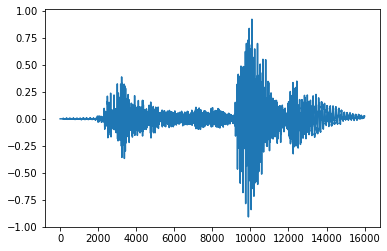

In [281]:
x_sg, b = torchaudio.load('newData3/train/32665_sample.wav')
plt.plot(x_sg[0])
Audio(x_sg[0], rate=16000)

In [241]:
idx = 3
ccount = 0
ccc = 6
for batch_index, (x_sg, y_region, y_angle, y_class, bce, _) in enumerate(valid_dataloader):
    x_sg = x_sg[idx:idx+1].cuda()
    #out_localizer1, out_localizer2, out_detector = net(x_sg)
    ccount += 1
    if ccount == ccc:
        break
Audio(x_sg.cpu().numpy()[0], rate=16000)

In [77]:
Audio(y_sg.cpu().numpy()[0], rate=16000)

In [21]:
layer = 3
print(mt_se_acts[layer][0].T)
print(sgL_se_acts[layer][0].T)
print(sgS_se_acts[layer][0].T)

print(((sgL_se_acts[layer][0] + sgS_se_acts[layer][0]) / 2).T)

print(np.mean(abs(mt_se_acts[layer][0] - sgL_se_acts[layer][0])))
print(np.mean(abs(mt_se_acts[layer][0] - sgS_se_acts[layer][0])))
print(np.mean(abs(mt_se_acts[layer][0]-(sgL_se_acts[layer][0] + sgS_se_acts[layer][0]) / 2)))

[[0.5739637  0.53853446 0.50650245 0.5374942  0.63722104 0.45590112
  0.4509031  0.46449876 0.5711607  0.5218454  0.5703634  0.558387
  0.53271115 0.4023588  0.53597665 0.5572525  0.49713004 0.50859725
  0.49874064 0.55584574 0.50727415 0.44089586 0.58677894 0.50498176
  0.5948892  0.6173903  0.39075652 0.5032422  0.53301257 0.41869885
  0.5964759  0.6311763  0.5739333  0.5477332  0.5746255  0.5210757
  0.5813275  0.5589664  0.477457   0.5140769  0.4575357  0.6347073
  0.57517946 0.43609744 0.5536986  0.47988546 0.56536126 0.555868
  0.44355336 0.583884   0.61036724 0.44096658 0.54855704 0.5538878
  0.4413636  0.48814383 0.50079894 0.44692254 0.5293474  0.52397454
  0.43398854 0.6134549  0.57804346 0.5060204  0.37903517 0.5119825
  0.5568344  0.47260797 0.45355546 0.5775325  0.54565996 0.5253103
  0.51062715 0.6315691  0.5633577  0.58750474 0.51231575 0.5675886
  0.4822092  0.49566278 0.5042831  0.5402684  0.49788266 0.50897294
  0.5491305  0.5385709  0.57528365 0.56811076 0.3821534  0

In [310]:
mt_se_acts[layer][0][:, 0].shape

(96,)

<BarContainer object of 32 artists>

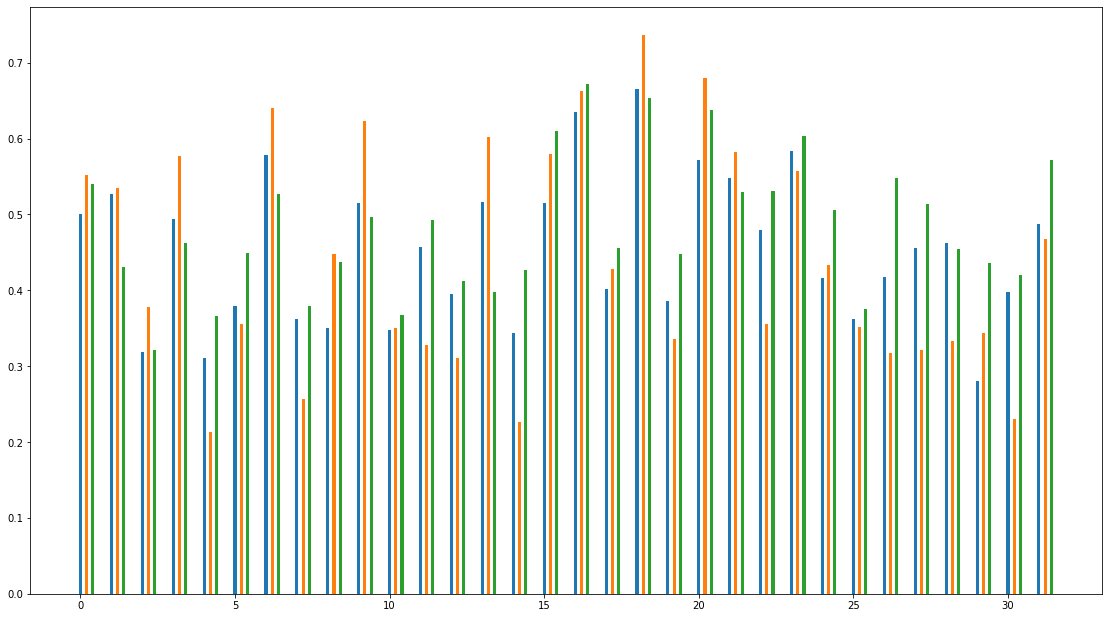

In [337]:
plt.figure(figsize=(19.2, 10.8))
layer = 0
plt.bar([i for i in range(len(mt_se_acts[layer][0]))], mt_se_acts[layer][0][:, 0], width=0.1)
plt.bar([i + 0.2 for i in range(len(mt_se_acts[layer][0]))], sgL_se_acts[layer][0][:, 0], width=0.1)
plt.bar([i + 0.4 for i in range(len(mt_se_acts[layer][0]))], sgS_se_acts[layer][0][:, 0], width=0.1)

In [29]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
out = cos(torch.tensor(l_l_act[0]), torch.tensor(l_s_act[0]))
print(out, out.shape)
print(torch.mean(out))

tensor([ 3.1369e-02,  8.8329e-02,  2.5626e-01, -5.0623e-01, -1.4291e-01,
         5.2498e-01,  1.5187e-01, -6.6560e-02, -8.4724e-02, -9.0622e-03,
        -4.9102e-01,  2.7258e-02,  2.5904e-02, -1.9013e-01,  1.2448e-01,
         4.8917e-01,  5.4504e-01, -4.4064e-01, -1.9410e-01, -1.1819e-01,
        -2.9726e-01,  5.8129e-01, -6.1936e-02,  3.2748e-01, -5.8477e-01,
        -3.2394e-01, -5.0303e-01,  4.5233e-01,  6.7289e-01, -1.7063e-01,
         6.1013e-01, -1.4329e-01, -5.0818e-01,  1.3786e-01, -3.4995e-01,
        -4.0154e-01, -2.9315e-02, -1.8118e-01,  2.2355e-01,  1.0591e-01,
        -3.7288e-01, -2.0558e-02,  1.6319e-02,  2.8190e-01, -3.4622e-01,
        -2.1945e-01, -1.6962e-01, -5.8907e-01, -2.5545e-01, -5.3986e-01,
         9.7348e-02,  3.1794e-01,  5.0786e-01, -4.2509e-01, -4.6435e-02,
        -3.5356e-01, -5.7848e-02,  6.6512e-04, -9.3798e-02,  5.1061e-01,
        -3.7140e-01, -1.8992e-01, -3.1048e-01, -3.3141e-01, -2.6685e-01,
         4.4706e-02, -9.3835e-02,  5.6927e-01,  2.2

In [151]:
sgL_acts[idx][0].shape

(240, 2000)

In [68]:
idx = 7
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
out = cos(torch.tensor(sgL_acts[idx][0]), torch.tensor(sgS_acts[idx][0]))
#print(out, out.shape)
print(torch.mean(out))

tensor(-0.0789)


In [122]:
def correlation_metric(y_pred, y_true):
    x = torch.Tensor(y_pred)
    y = torch.Tensor(y_true)
    vx = x - torch.mean(x)
    vy = y - torch.mean(y)
    cov = torch.sum(vx * vy)
    corr = cov / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)) + 1e-12)
    return corr

In [123]:
correlation_metric(f_s_act[0], f_l_act[0])

tensor(0.3341)

In [124]:
for i in range(0, 8):
    idx = i
    print(i+2, correlation_metric(sgL_acts[idx][0], sgS_acts[idx][0]))
    

2 tensor(0.3063)
3 tensor(0.3470)
4 tensor(0.2611)
5 tensor(0.2059)
6 tensor(0.1536)
7 tensor(0.1292)
8 tensor(0.0005)
9 tensor(0.1544)


In [125]:
correlation_metric(l_s_act[0], l_l_act[0])

tensor(0.2868)

In [21]:
idx = 5
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
out = cos(torch.tensor(sgL_acts[idx][0]), torch.tensor(sgS_acts[idx][0]))
print(out, out.shape)
print(torch.mean(out))

tensor([ 0.0037, -0.1179, -0.3314,  0.3043, -0.2926,  0.0383,  0.3332,  0.1413,
        -0.1558,  0.0238, -0.5233, -0.0556, -0.1437,  0.0977,  0.1951, -0.3626,
         0.4383, -0.3763, -0.0696,  0.0241,  0.2571,  0.2544, -0.1380, -0.2484,
        -0.1665,  0.1582,  0.1161,  0.6085,  0.5074,  0.1522, -0.0720, -0.2770,
        -0.2174, -0.2643,  0.1666,  0.0186,  0.0096, -0.1647,  0.2032,  0.0252,
         0.2305,  0.1768,  0.6143, -0.0262, -0.5230,  0.0153, -0.2913,  0.2963,
         0.0986,  0.0567, -0.0992, -0.5871, -0.1236, -0.0184,  0.6760,  0.2526,
         0.5746, -0.3600, -0.2202, -0.1663, -0.0474,  0.0538, -0.1933,  0.4652,
        -0.1841,  0.2905, -0.3952,  0.2723, -0.1197, -0.2296,  0.3690,  0.6549,
         0.3707,  0.0178,  0.3535, -0.0768,  0.3428,  0.4478,  0.6254,  0.3033]) torch.Size([80])
tensor(0.0500)


In [88]:
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
out = cos(torch.tensor(f_s_act[0][5:15]), torch.tensor(f_s_act[0][5:15]))
#print(out, out.shape)
print(torch.mean(out))

idx = 
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
out1 = cos(torch.tensor(mt_acts[idx][0]), torch.tensor(sgS_acts[idx][0]))
out2 = cos(torch.tensor(mt_acts[idx][0]), torch.tensor(sgL_acts[idx][0]))
out3 = cos(torch.tensor(sgL_acts[idx][0]), torch.tensor(sgS_acts[idx][0]))
print(out1.shape, torch.mean(out1) , torch.mean(out2), torch.mean(out3))

tensor(0.5812)
torch.Size([24]) tensor(0.0777) tensor(0.1670) tensor(0.1007)


In [115]:
out3 = cos(torch.tensor(l_l_act[0]), torch.tensor(l_s_act[0]))
print(out1.shape, torch.mean(out1) , torch.mean(out2), torch.mean(out3))

torch.Size([24]) tensor(0.0777) tensor(0.1670) tensor(0.4459)


In [31]:
idx = 7
pdist = nn.PairwiseDistance(p=2)
output1 = pdist(torch.tensor(mt_acts[idx][0]), torch.tensor(sgS_acts[idx][0]))
output2 = pdist(torch.tensor(mt_acts[idx][0]), torch.tensor(sgL_acts[idx][0]))
output3 = pdist(torch.tensor(sgL_acts[idx][0]), torch.tensor(sgS_acts[idx][0]))
print(torch.mean(output1), torch.mean(output2), torch.mean(output3))

tensor(69.9614) tensor(85.7057) tensor(64.4420)


In [360]:
torch.mean(pdist(torch.tensor(sgS_acts[idx][0]), torch.tensor(sgS_acts[idx][0])))

tensor(6.3247e-05)

In [282]:
output4 = pdist(torch.tensor(f_l_act[0]), torch.tensor(f_s_act[0]))
torch.mean(output4)

tensor(2.9721)

In [280]:
output3

tensor([ 9.5305, 14.1226,  9.9179, 23.0558, 16.7571, 21.9920, 27.0889, 17.8171,
         8.2351, 16.7551, 23.5582, 23.0147,  8.6254, 12.3897, 17.4392, 23.0511,
        20.6004, 17.9062, 10.2989, 13.5660, 15.1891, 11.6849, 46.9546,  9.4091,
        12.0356, 21.9667, 21.4746, 12.5082,  6.0429, 18.7355, 11.3660, 22.0334,
        14.5646, 13.6867, 16.4229, 13.5090, 23.0104, 14.5527,  9.3942,  4.9588,
        13.8035, 16.7876, 10.1442, 39.9251,  6.4757, 20.7136, 31.7948,  8.2655,
        24.3333, 11.6888, 11.6876, 13.2030, 16.4288, 14.2453, 15.9114, 10.2888,
        12.1309, 10.8493,  6.7992, 12.7939, 14.6442, 26.6089, 14.9616, 12.9936,
        16.1785, 16.6243, 11.4117, 18.3515, 18.2947, 10.8629, 10.4802, 14.0588,
        17.3158, 10.5385, 18.3195,  9.8080,  7.8353, 13.5595,  9.7008,  5.6685,
        12.3032, 13.5681, 15.3151, 11.6386, 21.0849, 20.7463, 16.6177, 14.4437,
        10.6820, 16.8636,  9.6937, 16.0940,  7.0325, 16.3985, 18.2240,  8.2066,
        27.6544, 24.2436, 13.8346, 10.87

In [241]:
torch.cdist(torch.tensor(sgL_acts[idx][0]), torch.tensor(sgS_acts[idx][0]), p=2)

torch.Size([32, 32])

In [231]:
for i in range(32):
    print(cos(torch.tensor(sgL_acts[idx][0][i:i+1]), torch.tensor(sgS_acts[idx][0][5:6])))

tensor([-0.1289])
tensor([-0.3062])
tensor([0.6178])
tensor([-0.1378])
tensor([0.1801])
tensor([0.0490])
tensor([-0.5721])
tensor([-0.7751])
tensor([0.0630])
tensor([-0.1599])
tensor([0.1328])
tensor([0.7261])
tensor([0.7063])
tensor([-0.4435])
tensor([0.3193])
tensor([-0.7218])
tensor([0.0843])
tensor([-0.0351])
tensor([-0.5233])
tensor([-0.0626])
tensor([-0.4277])
tensor([-0.3409])
tensor([0.1820])
tensor([-0.3613])
tensor([0.2835])
tensor([0.1521])
tensor([0.1625])
tensor([0.2033])
tensor([-0.3947])
tensor([0.0779])
tensor([0.8592])
tensor([-0.5167])


In [199]:
out3 * out1.shape[0]

tensor([ 29.7327,  30.9465,  21.9998,  13.8927,  24.7704,   1.5690,  27.5386,
         29.4736,  30.9548,  27.0724,  14.0898,  -9.3791,  18.8855,  18.2920,
         29.5359,  25.8117,   8.6148,  27.6905,  28.0991,  24.8225,  29.2763,
         15.9389,   7.0250,  15.0472, -17.2067,  17.9104,  24.2894,  -2.1759,
         -4.2955,  24.1028,  20.8262,  22.2478])

In [23]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
out = cos(torch.tensor(f_l_act[0]), torch.tensor(f_s_act[0]))
print(out, out.shape)
print(torch.mean(out))

tensor([-0.2210,  0.1249,  0.2241,  0.5611,  0.3303,  0.4223,  0.3109,  0.8803,
         0.1243,  0.3623,  0.9792,  0.0827, -0.0690,  0.8417,  0.3604,  0.2589,
         0.1969,  0.2795,  0.7271,  0.5745,  0.4359,  0.0513, -0.2564,  0.3475,
         0.3633,  0.6836,  0.3720,  0.6011,  0.6346, -0.1284,  0.8225,  0.6061]) torch.Size([32])
tensor(0.3714)


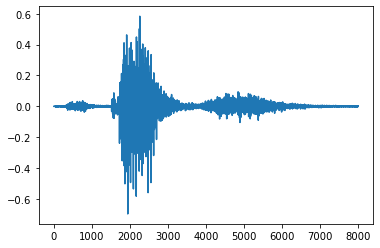

In [64]:
plt.plot(f_mt_act[0][1])

In [413]:
Audio(y_sg.cpu().numpy()[0], rate=16000)

In [177]:
Audio(x_sg.cpu().numpy()[0], rate=16000)

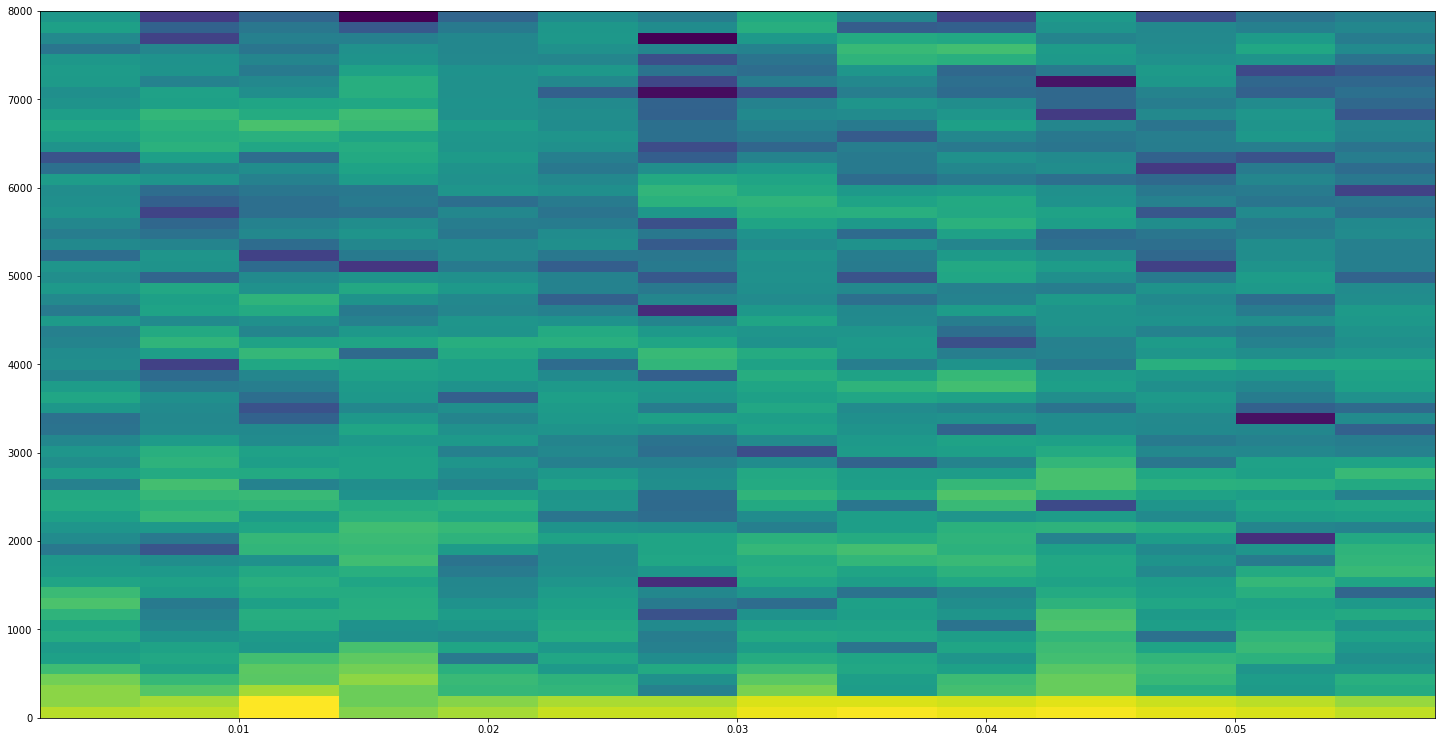

In [293]:
plt.figure(figsize=(25, 13))
for i in range(24):
    a = plt.specgram(l_l_act[0][i+0], Fs=16000, NFFT=128, noverlap=64)
    break

In [290]:
a[1]

array([   0. ,   62.5,  125. ,  187.5,  250. ,  312.5,  375. ,  437.5,
        500. ,  562.5,  625. ,  687.5,  750. ,  812.5,  875. ,  937.5,
       1000. , 1062.5, 1125. , 1187.5, 1250. , 1312.5, 1375. , 1437.5,
       1500. , 1562.5, 1625. , 1687.5, 1750. , 1812.5, 1875. , 1937.5,
       2000. , 2062.5, 2125. , 2187.5, 2250. , 2312.5, 2375. , 2437.5,
       2500. , 2562.5, 2625. , 2687.5, 2750. , 2812.5, 2875. , 2937.5,
       3000. , 3062.5, 3125. , 3187.5, 3250. , 3312.5, 3375. , 3437.5,
       3500. , 3562.5, 3625. , 3687.5, 3750. , 3812.5, 3875. , 3937.5,
       4000. , 4062.5, 4125. , 4187.5, 4250. , 4312.5, 4375. , 4437.5,
       4500. , 4562.5, 4625. , 4687.5, 4750. , 4812.5, 4875. , 4937.5,
       5000. , 5062.5, 5125. , 5187.5, 5250. , 5312.5, 5375. , 5437.5,
       5500. , 5562.5, 5625. , 5687.5, 5750. , 5812.5, 5875. , 5937.5,
       6000. , 6062.5, 6125. , 6187.5, 6250. , 6312.5, 6375. , 6437.5,
       6500. , 6562.5, 6625. , 6687.5, 6750. , 6812.5, 6875. , 6937.5,
      

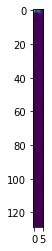

In [93]:
a[0].shape
plt.imshow(a[0])

IndexError: index 1 is out of bounds for axis 0 with size 1

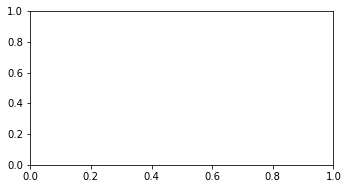

In [130]:
idx = 1
plt.figure(figsize=(25, 13))
for i in range(16):
    plt.subplot(4,4,i+1)
    a = plt.specgram(f_s_act[0][i+0], Fs=16000, NFFT=256)
    #plt.plot(f_l_act[0][i])

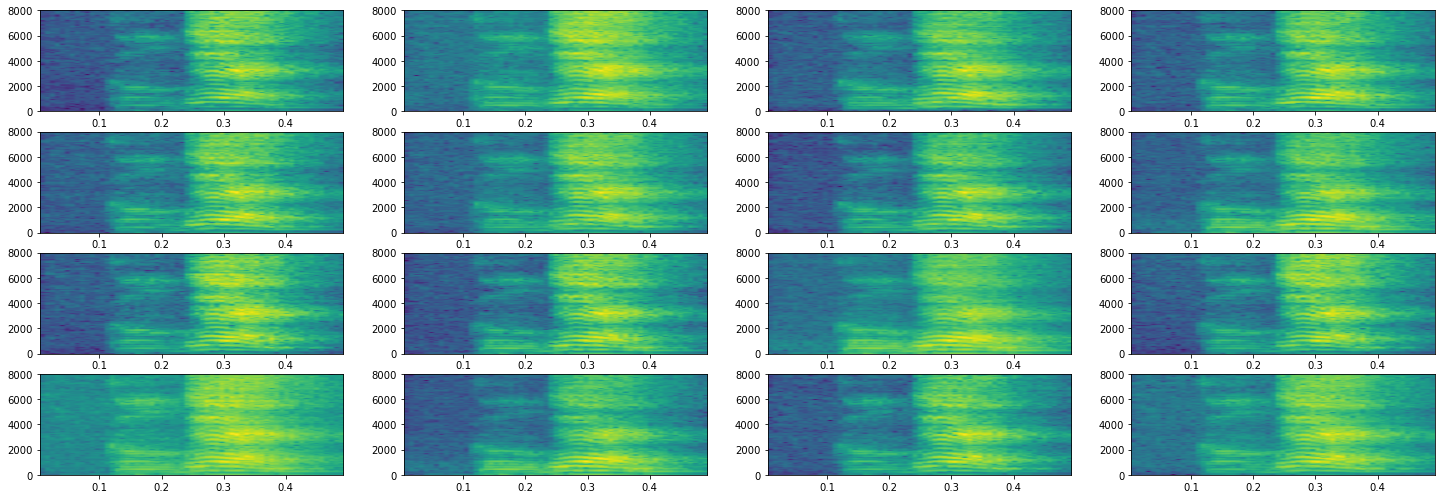

In [129]:
plt.figure(figsize=(25, 13))
for i in range(16):
    plt.subplot(6,4,i+1)
    a = plt.specgram(f_l_act[0][i], Fs=16000, NFFT=256)
    #plt.plot(f_l_act[0][i])

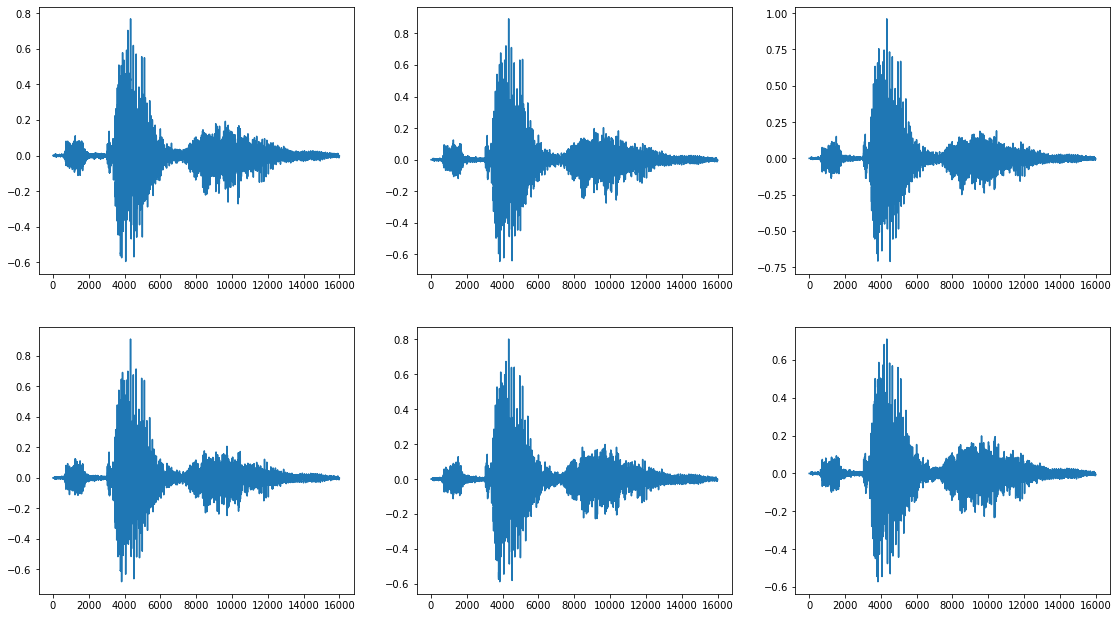

In [97]:
plt.figure(figsize=(19.2,10.8))
for i in range(6):
    plt.subplot(2,3,i+1)
    #a = plt.specgram(y_sg.cpu()[0][i], Fs=16000, NFFT=256, scale='dB')
    plt.plot(x_sg.cpu()[0][i])

In [145]:
Audio(x_sg.cpu().numpy()[0], rate=16000)

In [117]:
torchaudio.save('sample1_x.wav', x_sg.cpu()[0], 16000)

In [116]:
torchaudio.save('sample1.wav', y_sg.cpu()[0], 16000)

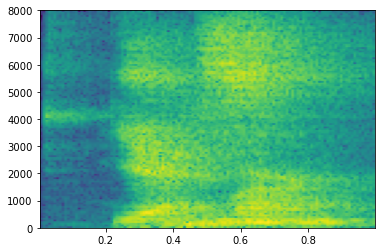

In [178]:
a = plt.specgram(x_sg.cpu()[0][0], Fs=16000, NFFT=256, scale='dB')

In [57]:
sgS_se_acts[7][0].shape

(480, 1)

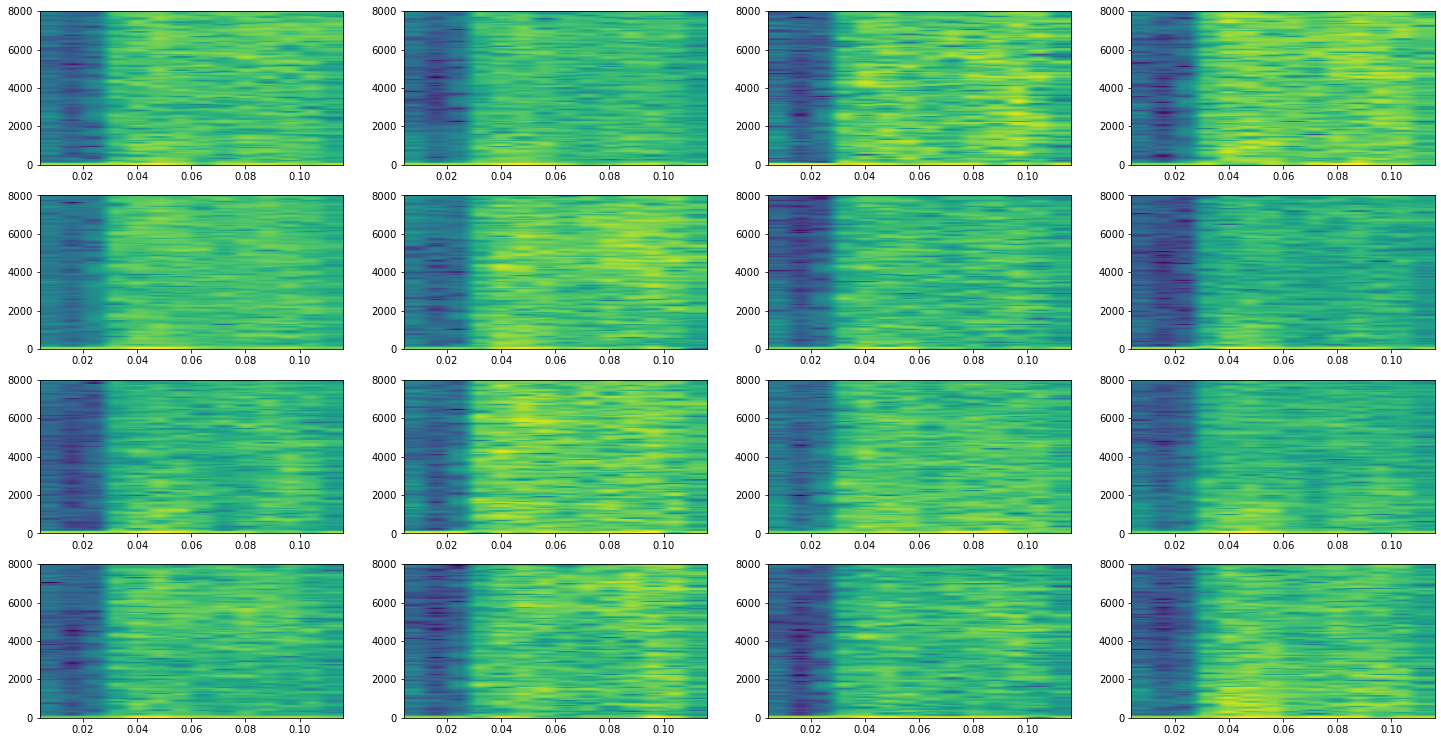

In [190]:
b = 1
idx = 4
plt.figure(figsize=(25, 13))
for i in range(16):
    plt.subplot(4,4,i+1)
    #plt.axis(False)
    a = plt.specgram(sgS_acts[idx][0][i+(24*b)], Fs=16000, NFFT=256)
    #plt.plot(sgL_acts[4][0][i])

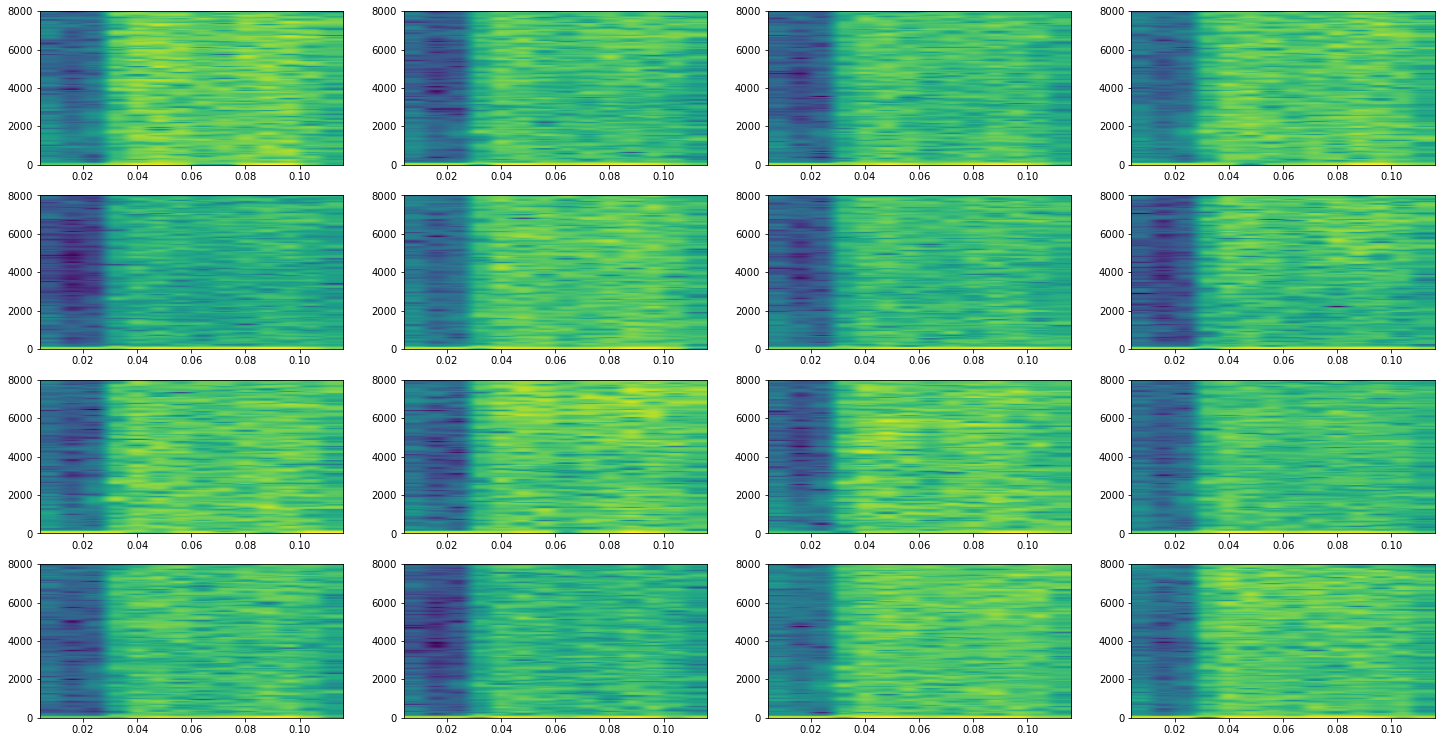

In [191]:
plt.figure(figsize=(25, 13))
for i in range(16):
    plt.subplot(4,4,i+1)
    #plt.axis(False)
    a = plt.specgram(sgL_acts[idx][0][i+(24*b)], Fs=16000, NFFT=256)
    #plt.plot(sgL_acts[4][0][i])

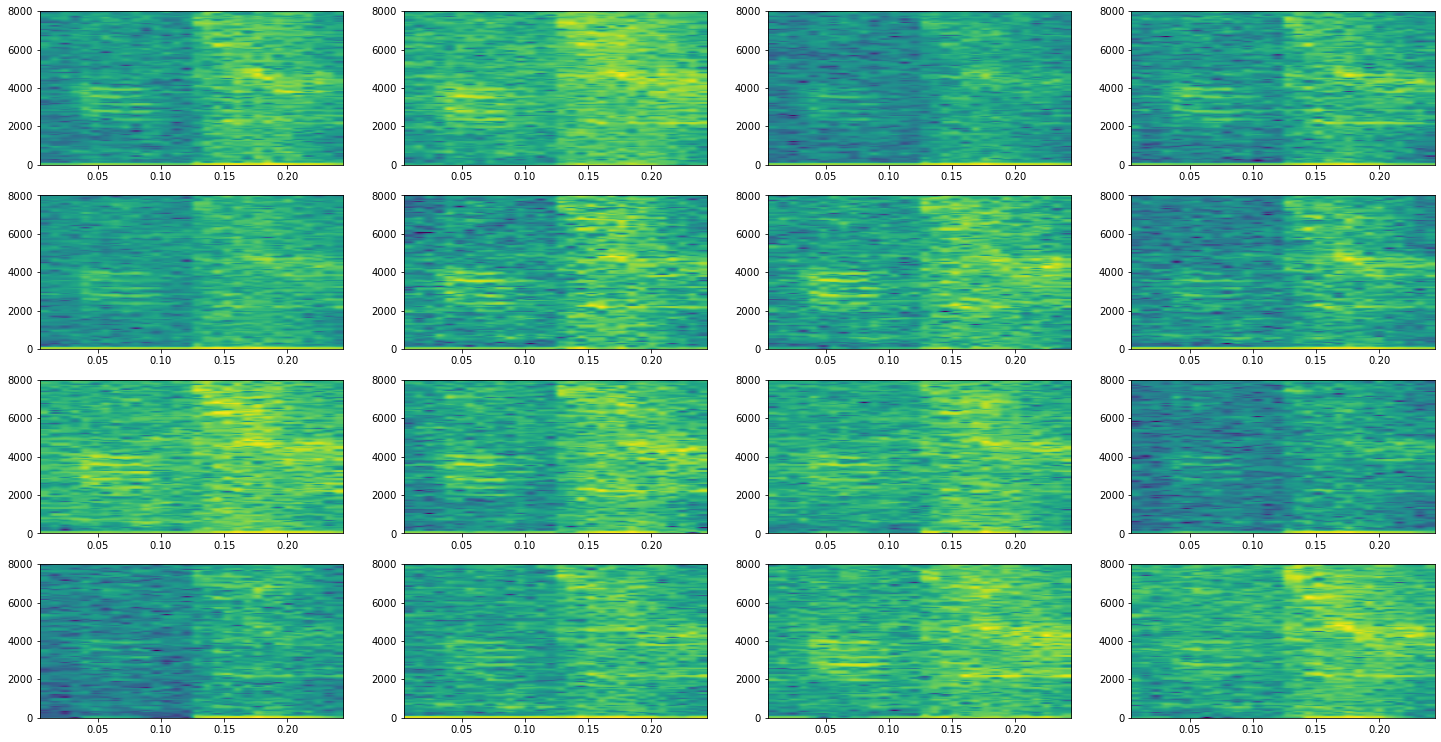

In [234]:
plt.figure(figsize=(25, 13))
for i in range(16):
    plt.subplot(4,4,i+1)
    #plt.axis(False)
    a = plt.specgram(mt_acts[idx][0][i+(24*b)], Fs=16000, NFFT=256)
    #plt.plot(sgL_acts[4][0][i])

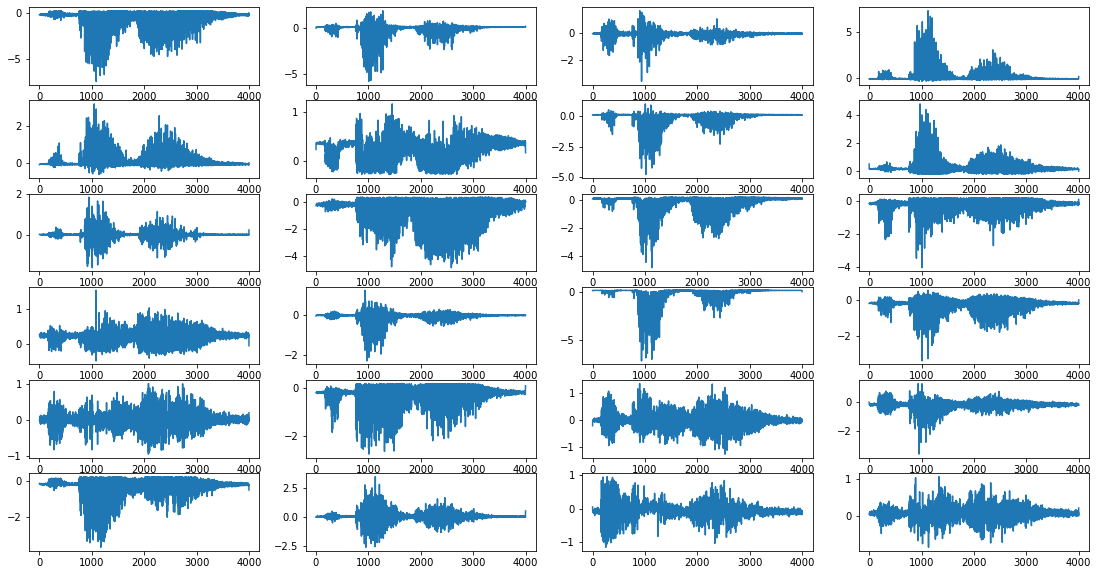

In [43]:
plt.figure(figsize=(19, 10))
for i in range(24):
    plt.subplot(6,4,i+1)
    #a = plt.specgram(mt_acts[1][0][i], Fs=16000, NFFT=128, noverlap=64)
    plt.plot(mt_acts[1][0][i])

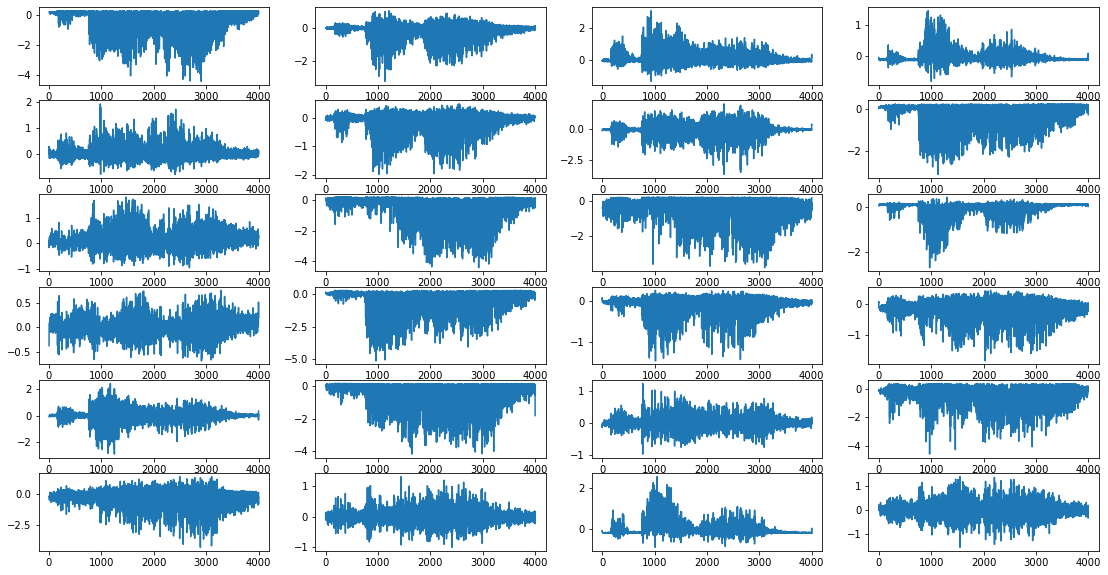

In [44]:
plt.figure(figsize=(19, 10))
for i in range(24):
    plt.subplot(6,4,i+1)
    #a = plt.specgram(mt_acts[2][0][i], Fs=16000, NFFT=128, noverlap=64)
    plt.plot(mt_acts[2][0][i])

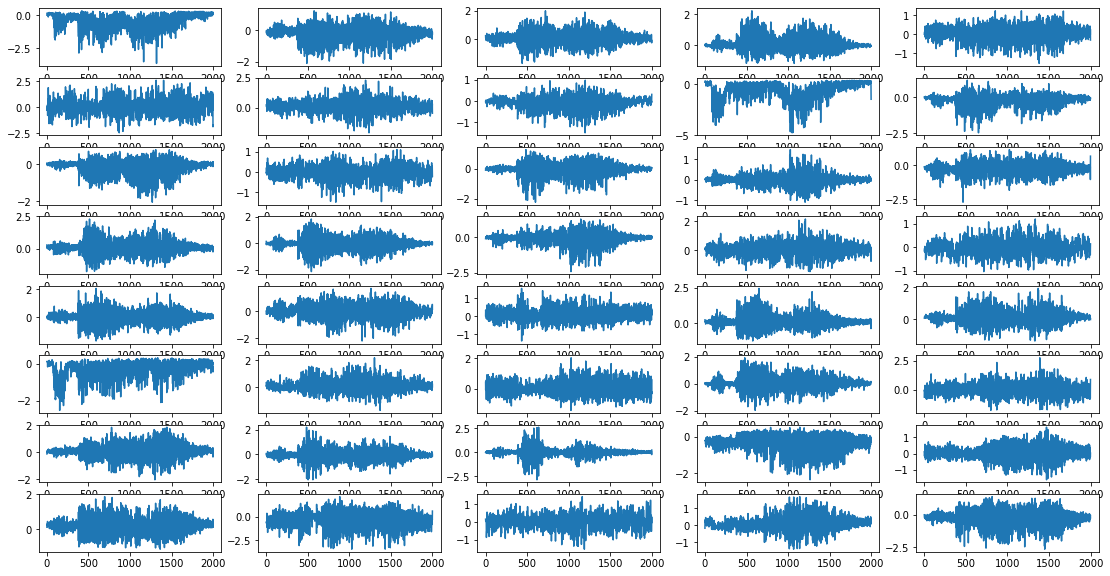

In [45]:
plt.figure(figsize=(19, 10))
for i in range(40):
    plt.subplot(8,5,i+1)
    #a = plt.specgram(mt_acts[3][0][i], Fs=16000, NFFT=64, noverlap=32)
    plt.plot(mt_acts[3][0][i])

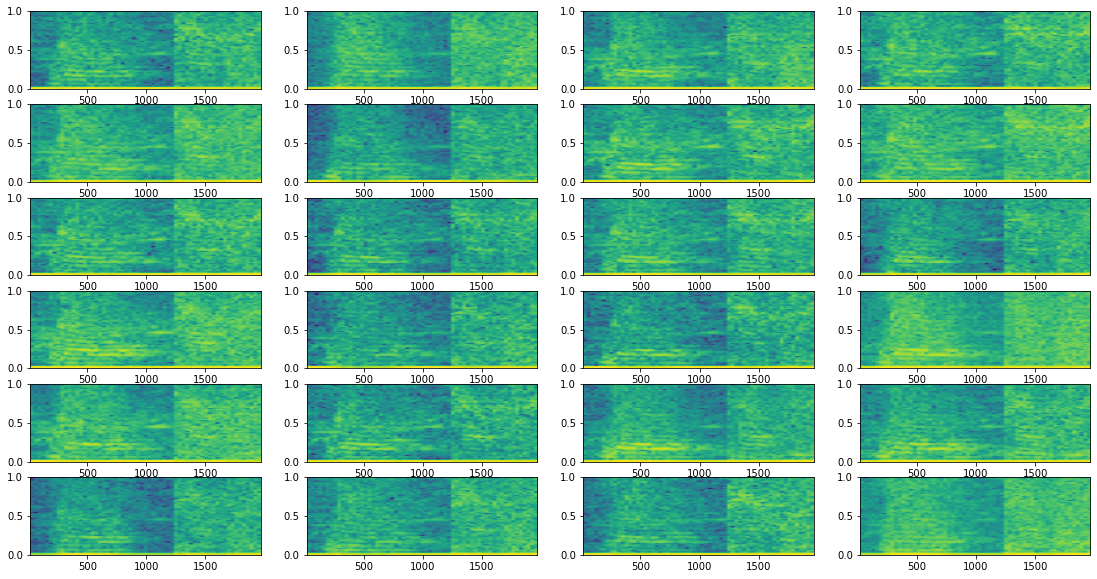

In [96]:
plt.figure(figsize=(19, 10))
for i in range(24):
    plt.subplot(6,4,i+1)
    a = plt.specgram(activations2[0][i], NFFT=128, noverlap=64)

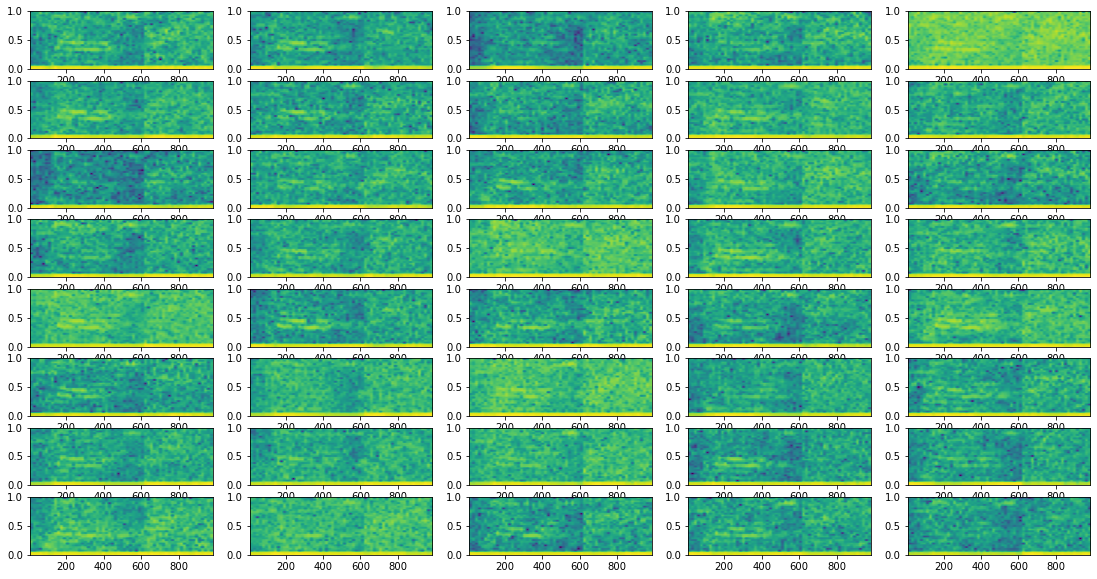

In [97]:
plt.figure(figsize=(19, 10))
for i in range(40):
    plt.subplot(8,5,i+1)
    a = plt.specgram(activations4[0][i], NFFT=64, noverlap=32)

torch.Size([129, 251, 2])


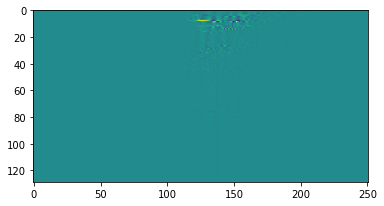

In [62]:
stft_x = torch.stft(x_sg.cpu()[0][0], n_fft=256)
print(stft_x.shape)
plt.imshow(stft_x[:,:,0])

torch.Size([129, 126, 2])
torch.Size([129, 126, 2])
torch.Size([129, 126, 2])
torch.Size([129, 126, 2])
torch.Size([129, 126, 2])
torch.Size([129, 126, 2])
torch.Size([129, 126, 2])
torch.Size([129, 126, 2])
torch.Size([129, 126, 2])
torch.Size([129, 126, 2])
torch.Size([129, 126, 2])
torch.Size([129, 126, 2])
torch.Size([129, 126, 2])
torch.Size([129, 126, 2])
torch.Size([129, 126, 2])
torch.Size([129, 126, 2])


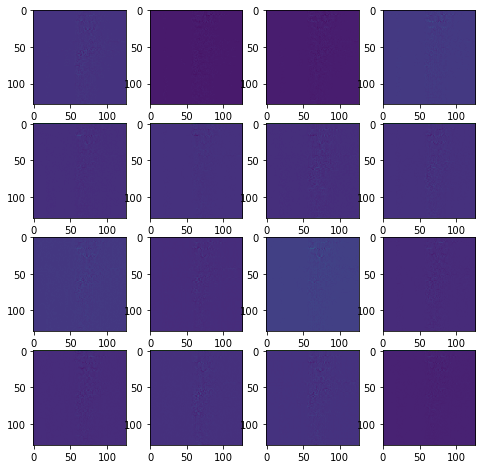

In [66]:
plt.figure(figsize=(8, 8))
for i in range(16):
    stft_at1 = torch.stft(torch.tensor(activations1[0])[i], n_fft=256)
    print(stft_at1.shape)
    plt.subplot(4,4, i+1)
    plt.imshow(stft_at1[:,:,0])

torch.Size([65, 126, 2])
torch.Size([65, 126, 2])
torch.Size([65, 126, 2])
torch.Size([65, 126, 2])
torch.Size([65, 126, 2])
torch.Size([65, 126, 2])
torch.Size([65, 126, 2])
torch.Size([65, 126, 2])
torch.Size([65, 126, 2])
torch.Size([65, 126, 2])
torch.Size([65, 126, 2])
torch.Size([65, 126, 2])
torch.Size([65, 126, 2])
torch.Size([65, 126, 2])
torch.Size([65, 126, 2])
torch.Size([65, 126, 2])
torch.Size([65, 126, 2])
torch.Size([65, 126, 2])
torch.Size([65, 126, 2])
torch.Size([65, 126, 2])
torch.Size([65, 126, 2])
torch.Size([65, 126, 2])
torch.Size([65, 126, 2])
torch.Size([65, 126, 2])


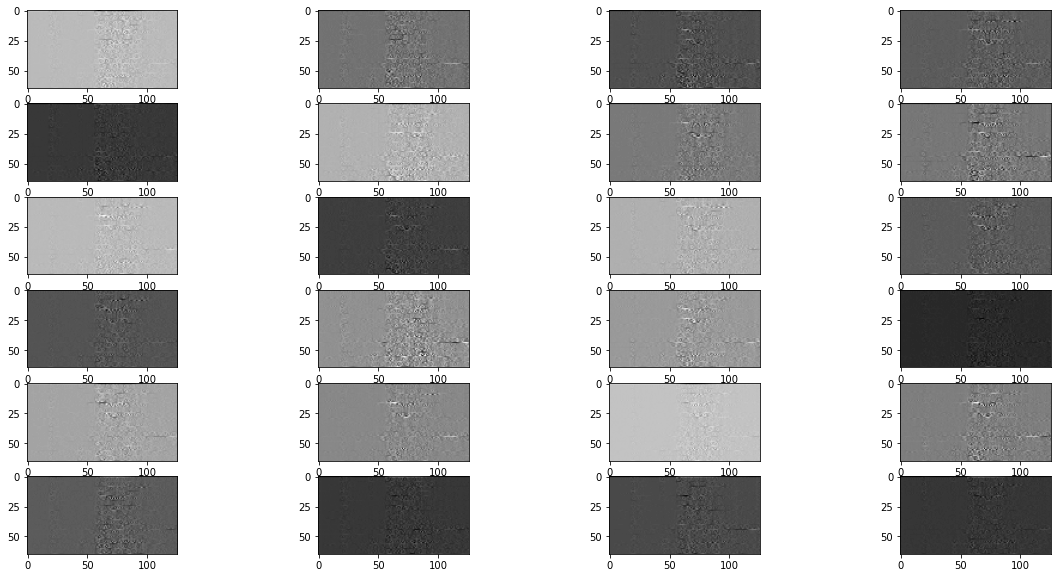

In [60]:
plt.figure(figsize=(20, 10))
for i in range(24):
    stft_at1 = torch.stft(torch.tensor(activations2[0])[i], n_fft=128)
    print(stft_at1.shape)
    plt.subplot(6,4, i+1)
    plt.imshow(stft_at1[:,:,0], cmap='gray')

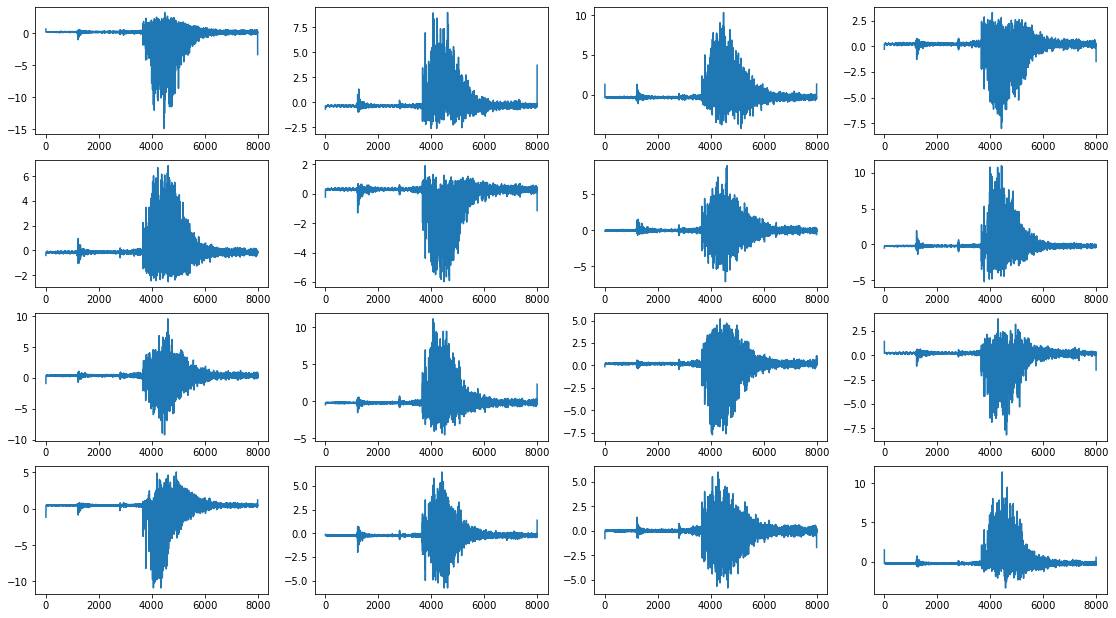

In [32]:
plt.figure(figsize=(19.2, 10.8))
for i, a in enumerate(activations1[0]):
    plt.subplot(4,4,i+1)
    plt.plot(a)

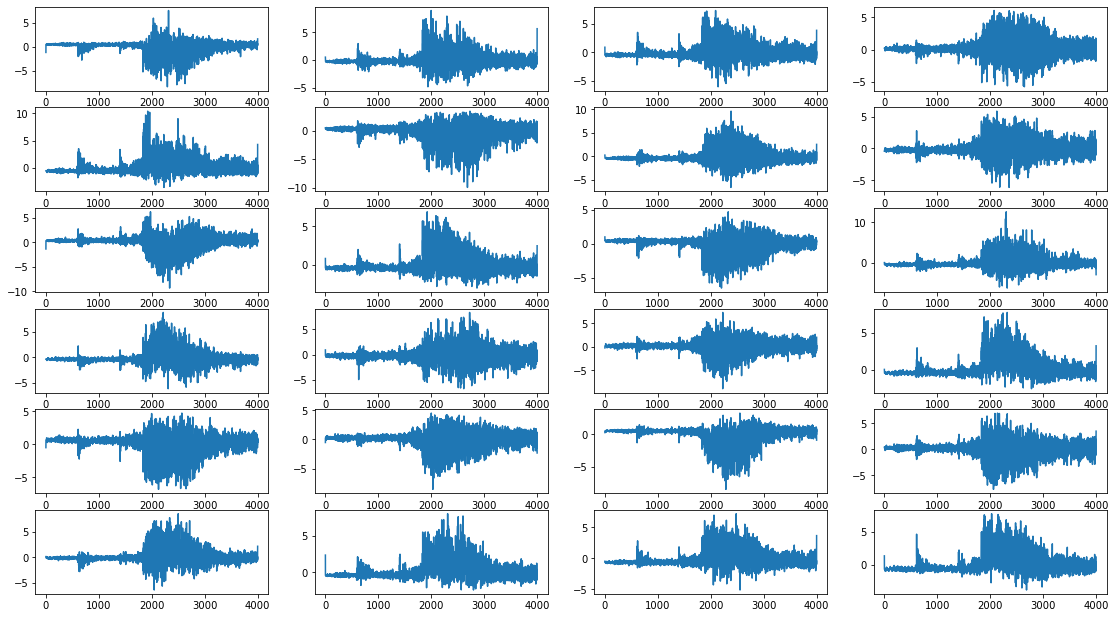

In [33]:
plt.figure(figsize=(19.2, 10.8))
for i, a in enumerate(activations2[0]):
    plt.subplot(6,4,i+1)
    plt.plot(a)

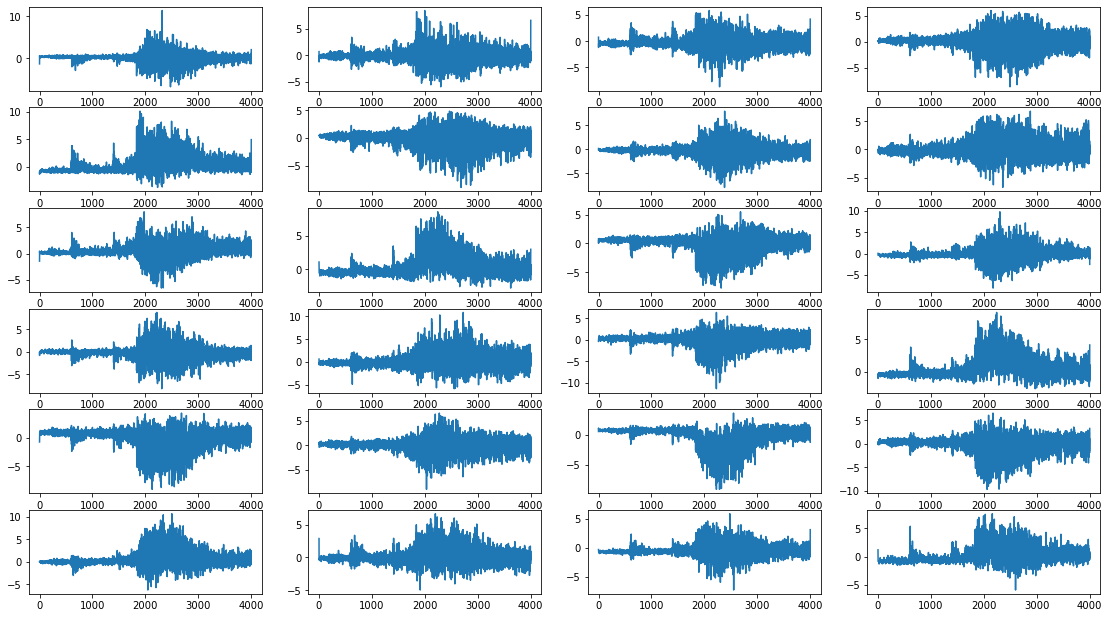

In [34]:
plt.figure(figsize=(19.2, 10.8))
for i, a in enumerate(activations3[0]):
    plt.subplot(6,4,i+1)
    plt.plot(a)

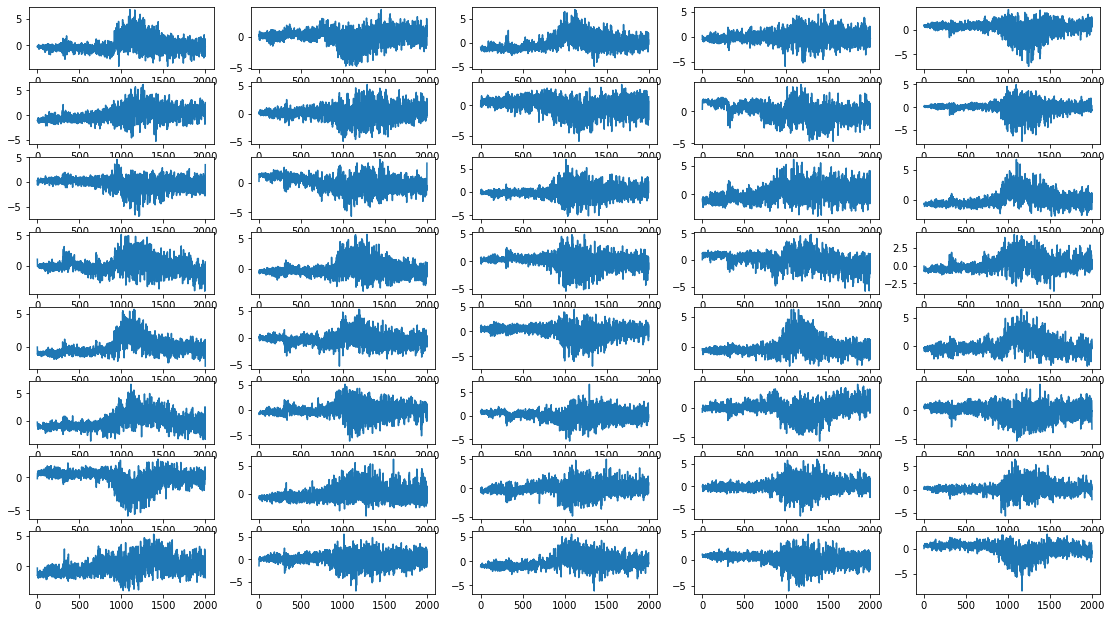

In [35]:
plt.figure(figsize=(19.2, 10.8))
for i, a in enumerate(activations4[0]):
    plt.subplot(8,5,i+1)
    plt.plot(a)

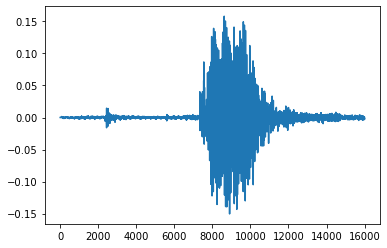

In [39]:
plt.plot(x_sg.cpu().data.numpy()[0][0])

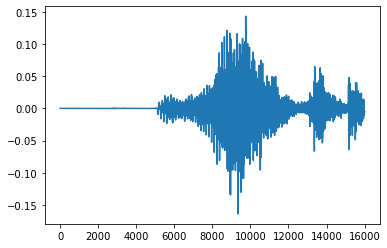

In [10]:
plt.plot(x_sg.cpu().data.numpy()[0][0])

In [196]:
def solution(number, k):
    answer = ''
    start = 0
    end = k+1
    while end < len(number)+1:
        sub_max_num = max(number[start:end])
        for j in range(start, end):
            if number[j] == sub_max_num:
                answer += number[j]
                k -= j - start
                start = j + 1
                end = start + k + 1
                break
    return answer

In [197]:
print(solution("1924", 2))
print(solution("1231234", 3))
print(solution("4177252841", 4))
print(solution("11", 1))

9 2 0 3 
9 2 0 3 
4 1 2 4 9
4 1 2 4 9
94
3 3 0 4 
3 3 0 4 
3 3 0 4 
2 1 3 5 3
2 1 3 5 3
3234
7 4 0 5 
7 4 0 5 
7 4 0 5 
7 2 3 6 7
5 2 4 7 77
5 2 4 7 77
8 1 6 8 775
8 1 6 8 775
775841
1 1 0 2 
1 1 1 3 1


ValueError: max() arg is an empty sequence

In [128]:
def solution(people, limit):
    answer = 0
    left = 0
    right = len(people) - 1
    people.sort()
    
    while left <= right:
        if people[left] + people[right] > limit:
            right -= 1
            answer += 1
        else:
            left += 1
            right -= 1
            answer += 1
        
    return answer

1111111112
